In [ ]:
# fetch data from BLS using `requests` library to access BLS API data
# https://www.bls.gov/developers/api_python.htm


import requests
import pandas as pd

# BLS API URL (Example: Unemployment Rate for different states)
BLS_API_URL = "https://api.bls.gov/publicAPI/v2/timeseries/data/LAUST480000000000003"

# Function to fetch data from BLS API
def fetch_bls_data():
    headers = {"Content-Type": "application/json"}
    response = requests.get(BLS_API_URL, headers=headers)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print("Failed to fetch data:", response.status_code)
        return None

# Fetch and display sample data structure (for review)
bls_data = fetch_bls_data()
bls_data

In [2]:
import seaborn as sns
print(sns.__version__)


0.13.2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [6]:
# 1: Load data (Replace with BLS data or CSV Import)
# data = {
#     "City": ["New York", "Chicago", "Houston", "Los Angeles", "San Francisco"],
#     "Employment rate (%)": [92, 88, 85, 90, 94],
#     "Job growth rate (%)": [3.2, 2.8, 2.5, 3.0, 3.5],
#     "Median salary ($)": [85000, 75000, 70000, 82000, 95000],
#     "Job openings": [50000, 40000, 30000, 45000, 48000]
# }

# # Create df
# df = pd.DataFrame(data)


df = pd.read_csv('/Users/yummy/Desktop/Portfolio/job-market-analysis/bls_job_data.csv')
df.head()

# Define major U.S. cities and their FIPS codes
major_cities = {
    "New York County, NY": "36061",
    "Cook County, IL": "17031",
    "Harris County, TX": "48201",
    "San Francisco County, CA": "06075",
    "Fulton County, GA": "13121",  # Atlanta
    "Los Angeles County, CA": "06037",
    "Dallas County, TX": "48113",
    "Miami-Dade County, FL": "12086"
}


In [7]:
# 3: Filter for major cities
df_filtered = df[df["area_fips"].astype(str).isin(major_cities.values())]

# columns for analysis
df_filtered = df_filtered[["area_fips", "month3_emplvl", "oty_month3_emplvl_pct_chg", 
                           "total_qtrly_wages", "qtrly_estabs"]]

# Rename columns
df_filtered.rename(columns={
    "area_fips": "FIPS Code",
    "month3_emplvl": "Employment level",
    "oty_month3_emplvl_pct_chg": "Job growth rate (%)",
    "total_qtrly_wages": "Total quarterly wages",
    "qtrly_estabs": "Job openings estimate",
}, inplace=True)

# Map city names to the dataset
df_filtered["City"] = df_filtered["FIPS Code"].map({v: k for k, v in major_cities.items()})

# Convert Total quarterly wages to Median salary estimate
df_filtered["Median salary estimate ($)"] = df_filtered["Total quarterly wages"] / (df_filtered["Employment level"] * 12)

# Drop FIPS Code
df_filtered = df_filtered.drop(columns=["FIPS Code"])

In [8]:
# 4: Min-Max scaling (data normalization)
def min_max_scaling(column):
    return (column - column.min()) / (column.max() - column.min())

df_filtered["Employment level (norm)"] = min_max_scaling(df_filtered["Employment level"])
df_filtered["Job growth rate (norm)"] = min_max_scaling(df_filtered["Job growth rate (%)"])
df_filtered["Median salary (norm)"] = min_max_scaling(df_filtered["Median salary estimate ($)"])
df_filtered["Job openings (norm)"] = min_max_scaling(df_filtered["Job openings estimate"])

In [9]:
# 5: Assign weights & compute JMS (Job Market Score)
weights = {
    "Employment level (norm)": 0.3,
    "Job growth Rate (norm)": 0.2,
    "Median salary (norm)": 0.3,
    "Job openings (norm)": 0.2
}

df_filtered["Job market index score"] = (
    df_filtered["Employment level (norm)"] * weights["Employment level (norm)"] +
    df_filtered["Job growth rate (norm)"] * weights["Job growth Rate (norm)"] +
    df_filtered["Median salary (norm)"] * weights["Median salary (norm)"] +
    df_filtered["Job openings (norm)"] * weights["Job openings (norm)"]
)

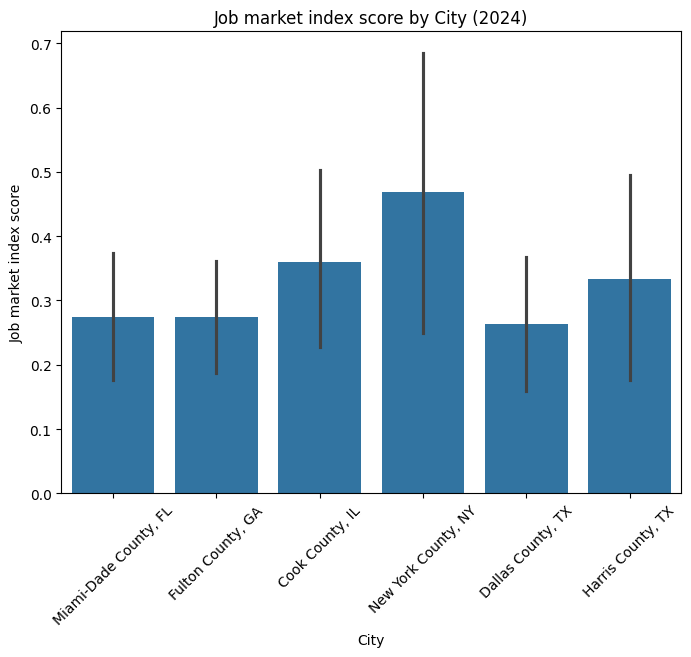

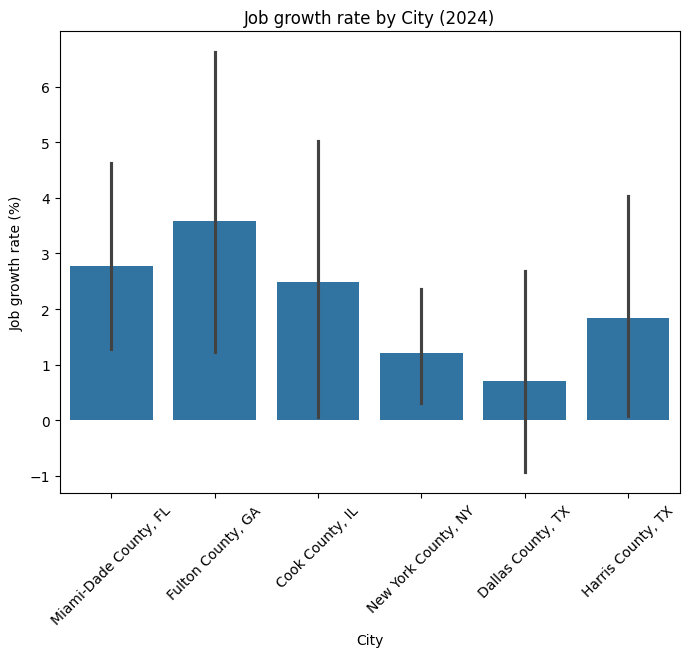

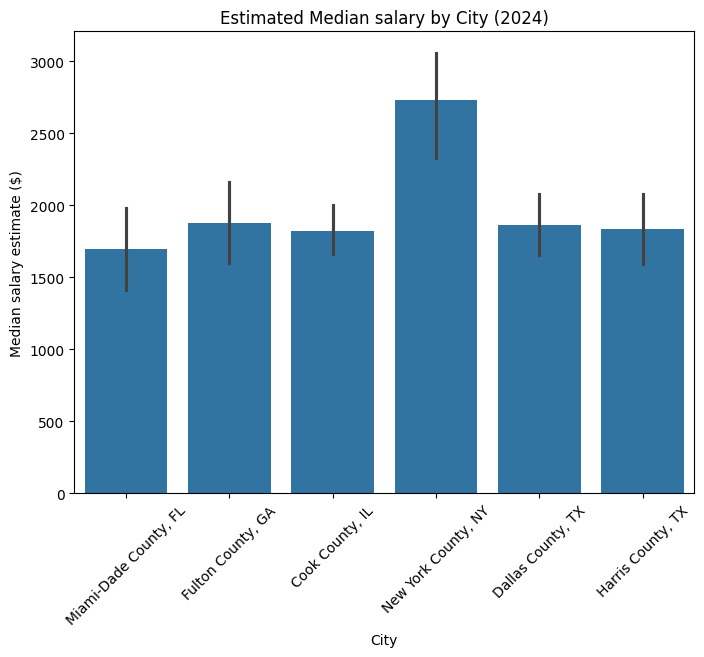

In [10]:

# # Ensure seaborn is installed and up-to-date
# %pip install seaborn --upgrade


# Step 6: Visuals

plt.figure(figsize=(8,6))
sns.barplot(x="City", y="Job market index score", data=df_filtered)
plt.xlabel("City")
plt.ylabel("Job market index score")
plt.title("Job market index score by City (2024)")
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(8,6))
sns.barplot(x="City", y="Job growth rate (%)", data=df_filtered) #, palette="coolwarm")
plt.xlabel("City")
plt.ylabel("Job growth rate (%)")
plt.title("Job growth rate by City (2024)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,6))
sns.barplot(x="City", y="Median salary estimate ($)", data=df_filtered) #, palette="Blues_d")
plt.xlabel("City")
plt.ylabel("Median salary estimate ($)")
plt.title("Estimated Median salary by City (2024)")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Display the cleaned dataset
print(df_filtered.sort_values(by="Job growth rate (%)", ascending=False))

# Display the cleaned dataset
print(df_filtered.sort_values(by="Job market index score", ascending=False))

In [12]:
# Display the columns in the DataFrame
print(df_filtered.columns)


Index(['Employment level', 'Job growth rate (%)', 'Total quarterly wages',
       'Job openings estimate', 'City', 'Median salary estimate ($)',
       'Employment level (norm)', 'Job growth rate (norm)',
       'Median salary (norm)', 'Job openings (norm)',
       'Job market index score'],
      dtype='object')


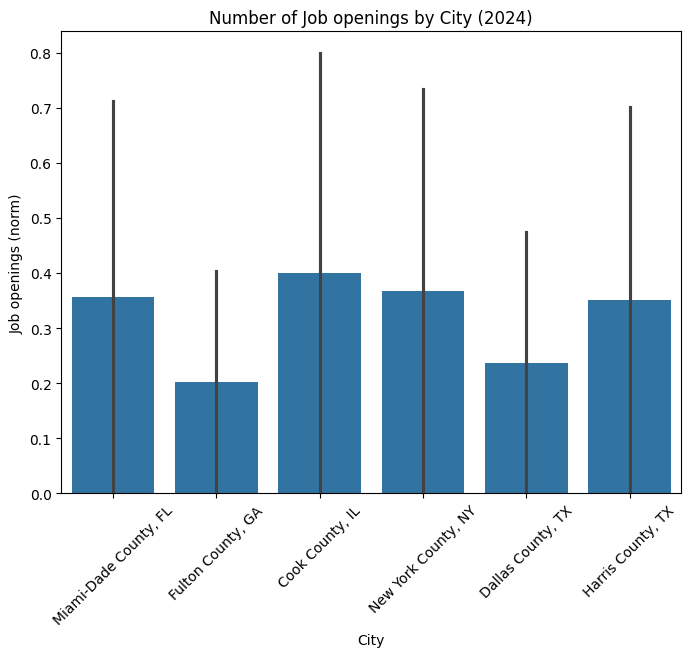

In [13]:
plt.figure(figsize=(8,6))
sns.barplot(x="City", y="Job openings (norm)", data=df_filtered)
plt.xlabel("City")
plt.ylabel("Job openings (norm)")
plt.title("Number of Job openings by City (2024)")
plt.xticks(rotation=45)
plt.show()

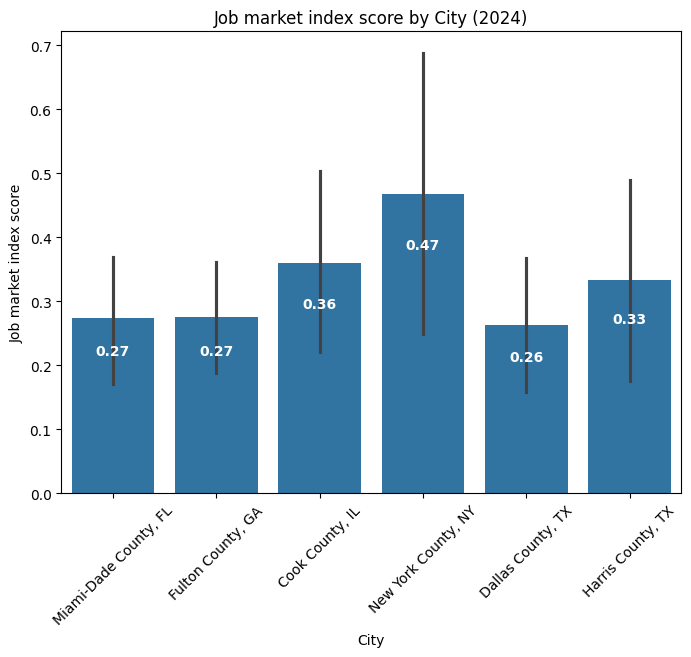

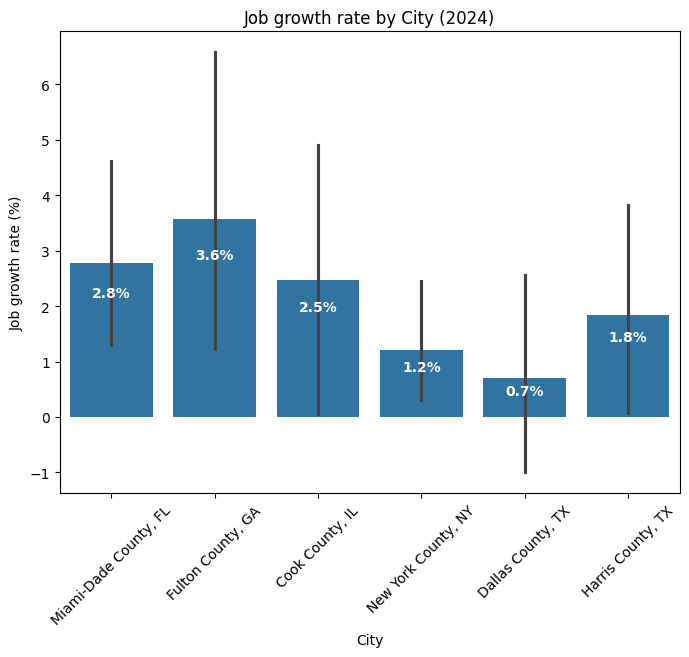

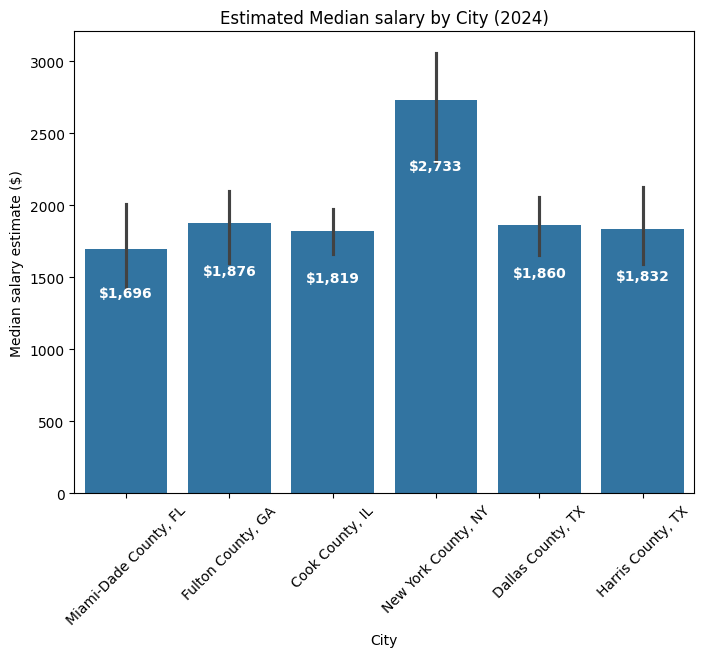

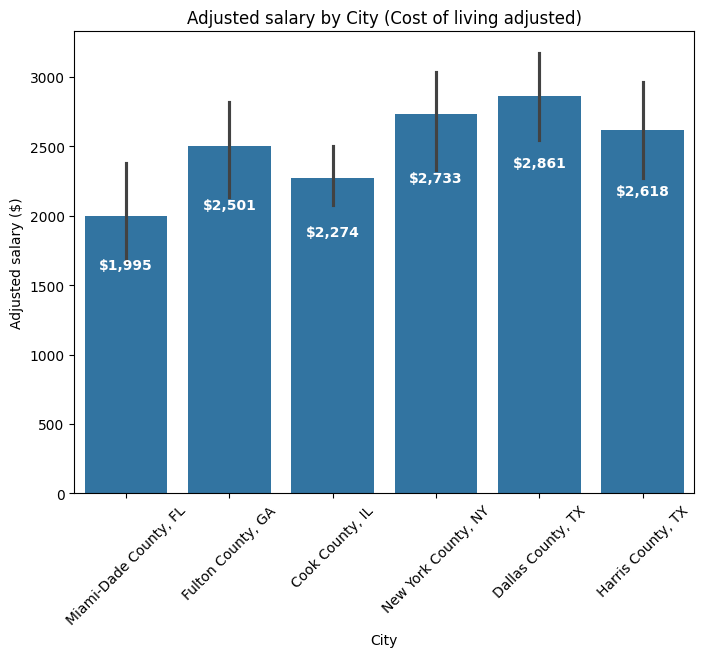

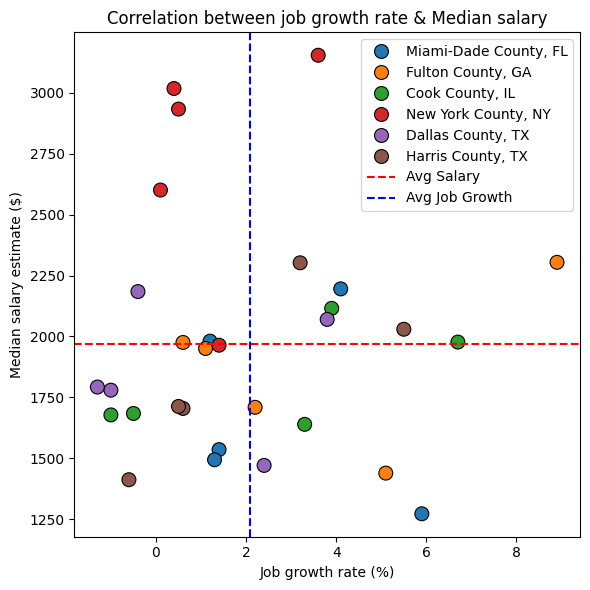

In [16]:
# 6: visuals2
# JMI score viz
plt.figure(figsize=(8,6))
ax = sns.barplot(x="City", y="Job market index score", data=df_filtered)
plt.xlabel("City")
plt.ylabel("Job market index score")
plt.title("Job market index score by City (2024)")
plt.xticks(rotation=45)

# data labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2, p.get_height() - (p.get_height() * 0.15)),
                ha='center', va='top', fontsize=10, color='white', fontweight='bold')

plt.show()

# Job growth rate Visualization
plt.figure(figsize=(8,6))
ax = sns.barplot(x="City", y="Job growth rate (%)", data=df_filtered)
plt.xlabel("City")
plt.ylabel("Job growth rate (%)")
plt.title("Job growth rate by City (2024)")
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width() / 2, p.get_height() - (p.get_height() * 0.15)),
                ha='center', va='top', fontsize=10, color='white', fontweight='bold')

plt.show()

# Median salary Visualization
plt.figure(figsize=(8,6))
ax = sns.barplot(x="City", y="Median salary estimate ($)", data=df_filtered)
plt.xlabel("City")
plt.ylabel("Median salary estimate ($)")
plt.title("Estimated Median salary by City (2024)")
plt.xticks(rotation=45)


for p in ax.patches:
    ax.annotate(f"${p.get_height():,.0f}", 
                (p.get_x() + p.get_width() / 2, p.get_height() - (p.get_height() * 0.15)),
                ha='center', va='top', fontsize=10, color='white', fontweight='bold')

plt.show()

# Assuming you have a cost of living index for each city
cost_of_living_index = {
    "New York County, NY": 1.0,
    "Cook County, IL": 0.8,
    "Harris County, TX": 0.7,
    "San Francisco County, CA": 1.2,
    "Fulton County, GA": 0.75,
    "Los Angeles County, CA": 1.1,
    "Dallas County, TX": 0.65,
    "Miami-Dade County, FL": 0.85
}

# Add Adjusted salary ($) column
df_filtered["Adjusted salary ($)"] = df_filtered.apply(
    lambda row: row["Median salary estimate ($)"] / cost_of_living_index[row["City"]],
    axis=1
)

# Adjusted salary (Cost of living adjusted)
plt.figure(figsize=(8,6))
ax = sns.barplot(x="City", y="Adjusted salary ($)", data=df_filtered)
plt.xlabel("City")
plt.ylabel("Adjusted salary ($)")
plt.title("Adjusted salary by City (Cost of living adjusted)")
plt.xticks(rotation=45)

# data labels
for p in ax.patches:
    ax.annotate(f"${p.get_height():,.0f}", 
                (p.get_x() + p.get_width() / 2, p.get_height() - (p.get_height() * 0.15)),
                ha='center', va='top', fontsize=10, color='white', fontweight='bold')

plt.show()

# Scatter plot - Correlation b/w job growth rate & Salary
plt.figure(figsize=(6,6), dpi=100)
sns.scatterplot(x="Job growth rate (%)", y="Median salary estimate ($)", hue="City", data=df_filtered, s=100, edgecolor="black")
plt.xlabel("Job growth rate (%)")
plt.ylabel("Median salary estimate ($)")
plt.title("Correlation between job growth rate & Median salary")
plt.axhline(df_filtered["Median salary estimate ($)"].mean(), color='r', linestyle='--', label="Avg Salary")
plt.axvline(df_filtered["Job growth rate (%)"].mean(), color='b', linestyle='--', label="Avg Job Growth")
plt.legend()
plt.tight_layout()
plt.show()

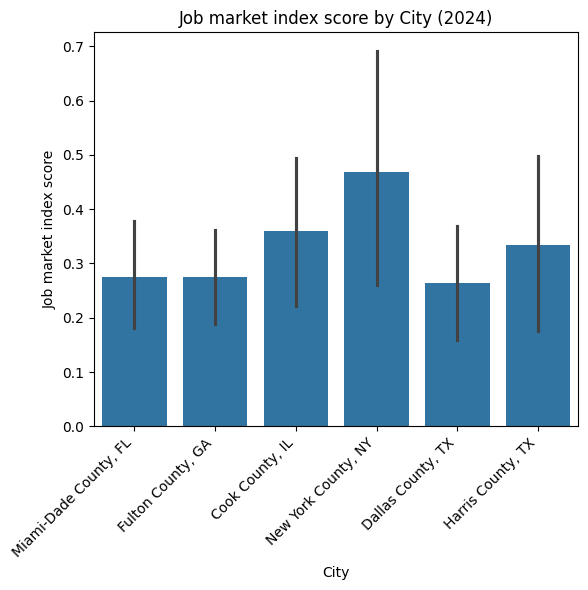

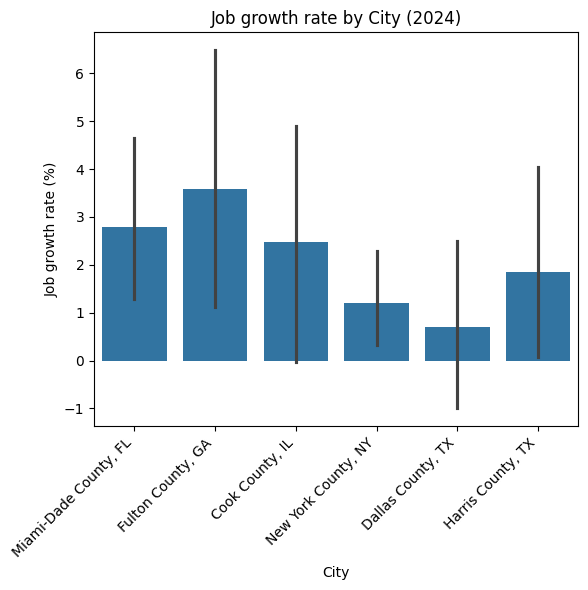

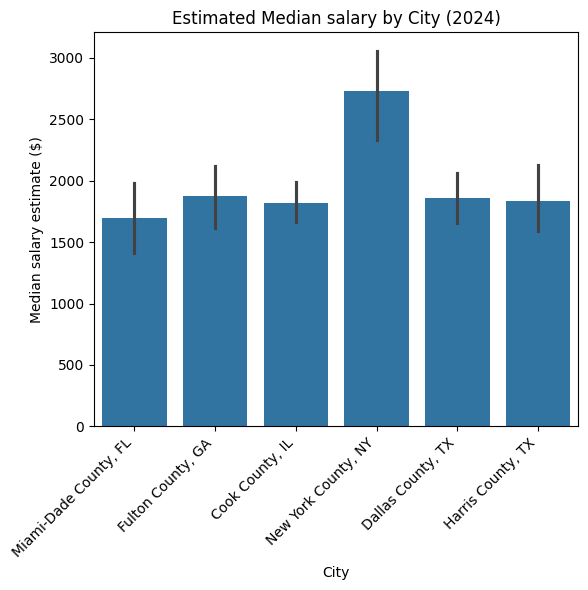

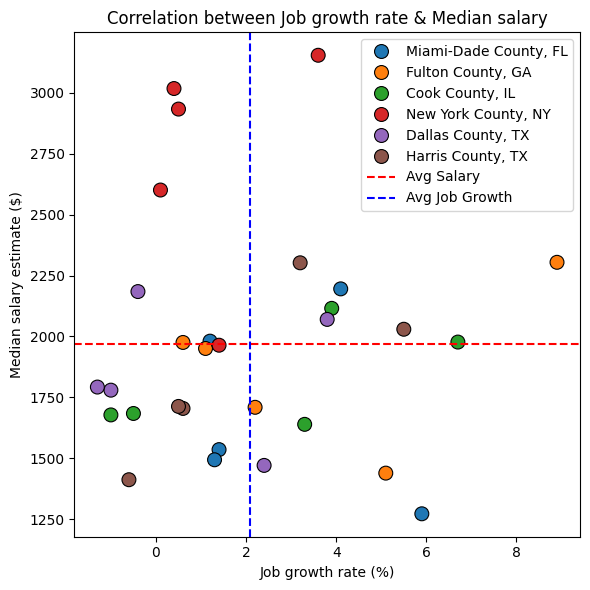

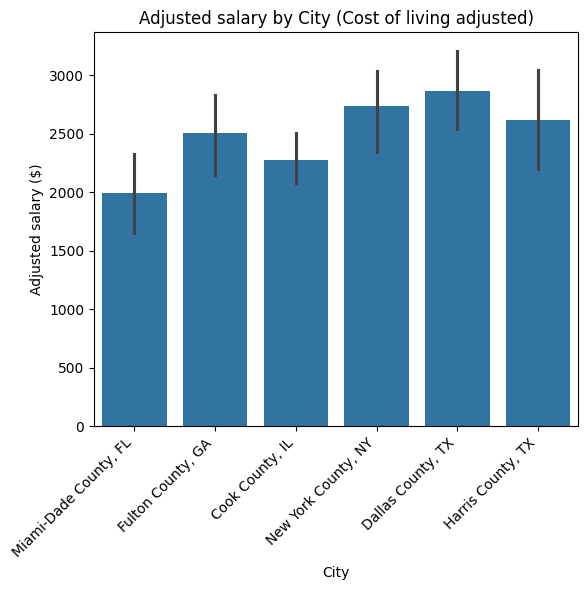

In [17]:
# 6: visuals

# Increase DPI for full-sized plots
plt.figure(figsize=(6,6), dpi=100)
ax = sns.barplot(x="City", y="Job market index score", data=df_filtered) 
plt.xlabel("City")
plt.ylabel("Job market index score")
plt.title("Job market index score by City (2024)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Prevents cropping of the figure
plt.show()


plt.figure(figsize=(6,6), dpi=100)
ax = sns.barplot(x="City", y="Job growth rate (%)", data=df_filtered)  
plt.xlabel("City")
plt.ylabel("Job growth rate (%)")
plt.title("Job growth rate by City (2024)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6), dpi=100)
ax = sns.barplot(x="City", y="Median salary estimate ($)", data=df_filtered)  
plt.xlabel("City")
plt.ylabel("Median salary estimate ($)")
plt.title("Estimated Median salary by City (2024)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Scatter plot - Correlation b/w Job growth rate & salary
plt.figure(figsize=(6,6), dpi=100)
sns.scatterplot(x="Job growth rate (%)", y="Median salary estimate ($)", hue="City", data=df_filtered, s=100, edgecolor="black")
plt.xlabel("Job growth rate (%)")
plt.ylabel("Median salary estimate ($)")
plt.title("Correlation between Job growth rate & Median salary")
plt.axhline(df_filtered["Median salary estimate ($)"].mean(), color='r', linestyle='--', label="Avg Salary")
plt.axvline(df_filtered["Job growth rate (%)"].mean(), color='b', linestyle='--', label="Avg Job Growth")
plt.legend()
plt.tight_layout()
plt.show()

# Adjusted salary (Cost of Living Adjusted)
plt.figure(figsize=(6,6), dpi=100)
ax = sns.barplot(x="City", y="Adjusted salary ($)", data=df_filtered)  
plt.xlabel("City")
plt.ylabel("Adjusted salary ($)")
plt.title("Adjusted salary by City (Cost of living adjusted)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

